# Optimise rotation parameter of known OWF sites

import

In [117]:
import os
from platypus import NSGAII, Problem, Real, Integer, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job, Archive, Solution, nondominated, InjectedPopulation, Mutation, ParetoDominance, Variator, Algorithm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
from OSGridConverter import latlong2grid, grid2latlong
import matplotlib
import plotly.express as px
import seaborn
import itertools

helpers

In [118]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518/data')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\data


In [119]:
def getCorners(lon, lat, turbnum):

    lonRads = np.radians(lon)
    latRads = np.radians(lat)

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # N turbines * 500m radius, into km 
    distance = int(length_turbnum * 0.5)

    corners = []

    for bearing in [45, 135, 225, 315]:
        bearingRads = np.radians(bearing)

        maxLatRads = np.arcsin(np.sin(latRads) * np.cos(distance / 6371) + np.cos(latRads) * np.sin(distance / 6371) * np.cos(bearingRads))
        maxLonRads = lonRads + np.arctan2(np.sin(bearingRads) * np.sin(distance / 6371) * np.cos(latRads), np.cos(distance / 6371) - np.sin(latRads) * np.sin(maxLatRads))

        maxLat = np.degrees(maxLatRads)
        maxLon = np.degrees(maxLonRads)

        corners.append([maxLon, maxLat])

    return corners

OWF problem

In [120]:
class OWF(Problem):
    def __init__(self, lon_limits, lat_limits, day_limits, turbnum_limits, data, map_polygon, wrecks_and_obstructions, shipping_density):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        """
        super(OWF, self).__init__(4, 4, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits
        self.turbnum_limits = turbnum_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        #lat_range = lat_limits[1] - lat_limits[0]
        #lon_range = lon_limits[1] - lon_limits[0]

        # experimentally defined site size limitations
        #lat_range = lon_range = 0.007201325686340829
        #lon_range = 5.203365643890723e-07

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types[:] = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            Integer(self.turbnum_limits[0], self.turbnum_limits[1]) # number of turbines as analogy for area of farm
        ]

        self.directions[:] = [
            Problem.MINIMIZE,   # minimise inverse of Velocity Potential (i.e. maximise Velocity Potential)
            Problem.MINIMIZE,   # minimise inverse of velocity potential density (i.e. maximise velocity potential density)
            Problem.MINIMIZE,   # minimise shipping density at solution
            Problem.MINIMIZE,   # minimise wrecks and obstructions within solution
        ]

        self.constraints[:] = [
           ">0.999",  # constrain valid shapes to have ~100% intersection with site boundary
           ">-40",   # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
        ]

        self.parameter_testing = {} # for storing parameters altered during testing and identifying solution ranks

    def evaluate(self, solution, verbose=False):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = lon, lat = x[1:3]
        turbnum = x[3]

        q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)   

        def rotate(points, origin, angle):
            xy = (points - origin) * np.exp(complex(0, angle)) + origin
            return xy.real, xy.imag
        
        q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
        q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        shapely_polygon = Polygon(points)

        target = shapely_polygon.area
        maxR = pow(target/3.141593, 0.5)
        tolerance = 0.00001
        lower_bound = 0.0001
        outer_limit, inner_limit = 20, 20 # max number of iterations for outer and inner loops before giving up
        outer_count, inner_count = 0, 0

        # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
        while True:
            intersection = shapely_polygon.intersection(self.map_polygon)

            if 1 - (intersection.area / shapely_polygon.area) > lower_bound:
                
                low, high = 0, maxR

                inner_count = 0
                while True:
                    middle=0.5*(low+high)
                    
                    newPolygon = intersection.buffer(middle)
                    
                    if (high-low) < tolerance:
                        break
                    
                    if newPolygon.area < target:
                        low = middle
                    else:
                        high = middle

                    inner_count += 1
                    if inner_count > inner_limit:
                        break

                shapely_polygon = newPolygon
            else:
                break   # exit once difference is empty or below lower bound

            outer_count += 1
            if outer_count > outer_limit:
                break
        
        print(f"outer_count: {outer_count}, inner_count: {inner_count}")

        # use deformed points to create new polygon for data extraction
        points = np.array(shapely_polygon.exterior.coords)
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            depth = -np.inf
            velocity_potential_mean = np.inf
            velocity_potential_stability = np.inf
        else:
            # get max depth from bathymetric data polygon
            # with contraints, ensure turbines can be placed in any section of area
            depth = data_polygon["Depth"].max()

            velocity_potential = data_polygon.drop(['Lon', 'Lat', 'Depth'], axis=1)

            velocity_potential_stability = velocity_potential.std(axis=1).mean()

            velocity_potential_mean = velocity_potential.mean(axis=1).mean()

        # get all wrecks and obstructions within polygon
        wrecks_and_obstructions = self.wrecks_and_obstructions[
            polygon.contains_points(self.wrecks_and_obstructions[["longitude", "latitude"]].values)
        ]
        # fitness is number of wrecks or obstructions inside polygon (less is better)
        wrecks_and_obstructions = len(wrecks_and_obstructions)

        # get shipping density by locating density polygon which contains center point
        shipping_densities = []
        for i, row in self.shipping_density.iterrows():
            # test if center is within row['polygon']
            if row['polygon'].contains_point(center):
                # contribution of shipping density per grid square is based on intersection with that grid square
                shipping_polygon_intersection = shapely_polygon.intersection(row['shapely_polygon']).area / shapely_polygon.area
                shipping_densities.append(row['yearly_avg']*shipping_polygon_intersection)
        
        # catch out of bounds errors
        if len(shipping_densities) == 0:
            shipping_density = np.inf
        else:
            shipping_density = np.mean(shipping_densities)

        # calculate intersection area between map polygon and solution polygon
        intersection = shapely_polygon.intersection(self.map_polygon).area / shapely_polygon.area        

        solution.objectives[:] = [
            -velocity_potential_mean,   # negate to maximise
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]
        
        solution.constraints[:] = [
            intersection,
            depth,
        ]


data

In [121]:
data = pd.read_csv("UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 228)

print(f"Latitude range: {lat_range}, Longitude range: {lon_range}")

print(data.head())

Latitude range: (53.486257927, 54.1), Longitude range: (0.5, 2.5571098)
        Lon        Lat          0          1          2          3          4  \
0  0.908810  53.508833 -4888854.5 -2964274.8 -1966400.0 -1944809.2 -322963.75   
1  0.982291  53.615490 -4988734.5 -3007930.2 -2047237.6 -2029393.5 -354367.40   
2  0.827796  53.586244 -4784387.0 -2952906.5 -1962346.2 -1973532.0 -356079.72   
3  0.837720  53.702704 -4801098.0 -2978041.2 -2017788.0 -2047978.2 -395331.00   
4  1.000396  53.708305 -5014005.5 -3031230.2 -2096183.8 -2092127.0 -384673.72   

           5          6          7  ...        220        221        222  \
0  1918140.2  2201700.2  497169.94  ...  3623697.0  3458370.5  3322026.8   
1  1893077.1  2230719.8  457650.47  ...  3645998.0  3475556.8  3341163.8   
2  1899125.8  2204834.5  470712.70  ...  3644461.0  3473458.5  3349537.8   
3  1871085.8  2224391.5  432494.90  ...  3669871.5  3497450.5  3374911.8   
4  1869927.0  2249043.0  425658.60  ...  3665922.8  3491546.0

In [122]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


In [123]:
wrecks_and_obstructions = pd.read_csv("UK east coast wrecks and obstructions.csv")

In [124]:
shipping_density = pd.read_csv("UK east coast shipping density 2015.csv")

shipping_density['corner'] = shipping_density['polygon'].apply(lambda x: eval(x)[0])    # get first corner of polygon
shipping_density['shapely_polygon'] = shipping_density['polygon'].apply(lambda x: Polygon(eval(x)))   # convert polygon to shapely polygon
shipping_density['polygon'] = shipping_density['polygon'].apply(lambda x: path.Path(eval(x)))   # convert polygon to matplotlib path

In [125]:
known_owf_locations = pd.read_csv("UK east coast wind energy locations.csv")

turbnum_range = (165, 174)  # min max turbnums in known truthes

# filter out Hornsea 3 and 4, as still under construction
known_owf_locations = known_owf_locations[known_owf_locations['TURBNUM'].isin([165, 174])]
known_owf_locations

,LAT,LNG,EASTING,NORTHING,TURBNUM
2,53.959745,1.541901,632326,457349,165.0
3,53.681258,1.422626,626000,426000,174.0


custom GA to evaluate solutions

In [126]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    turbnum_limits=turbnum_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)

In [127]:
class CustomSelector(object):
    
    def __init__(self):
        super(CustomSelector, self).__init__()

        # define defaults in case of needing tournament selection
        self.tournament_size = 2
        self.dominance = ParetoDominance()
        
    def select(self, n, population):
        # handle case where population == number of parents (n)
        if len(population) == n:
            return population
        else:
            # else use tournament selection to select n parents
            return list(map(self.select_one, itertools.repeat(population, n)))
    
    def select_one(self, population):
        winner = random.choice(population)
        
        for _ in range(self.tournament_size-1):
            candidate = random.choice(population)
            flag = self.dominance.compare(winner, candidate)
            
            if flag > 0:
                winner = candidate
                
        return winner

In [128]:
class GASkip(Variator):
    # skip GA mutation/crossover process
    
    def __init__(self):
        super(GASkip, self).__init__(0)

    def evolve(self, parents):
        children = []
        for parent in parents:
            child = copy.deepcopy(parent)
            children.append(child)
        return children

In [129]:
class GAEvaluator(Algorithm):
    def __init__(self, problem,
                 population,
                 **kwargs):
        super(GAEvaluator, self).__init__(problem, **kwargs)
        self.population = population
        self.population_size = len(population)
        self.result = []
            
    def initialize(self):
        self.evaluate_all(self.population)

optimise rotation

In [130]:
hornsea1 = []
hornsea2 = []

for idx, row in known_owf_locations.iterrows():
    turbnum = problem.types[3].encode(row["TURBNUM"])

    for angle in range(0, 360):
        sol = Solution(problem)    
        sol.variables[:] = [angle, row["LNG"], row["LAT"], turbnum]

        # append solution to known solutions
        if problem.types[3].decode(turbnum) == 174:
            hornsea1.append(sol)
        else:
            hornsea2.append(sol)

print(f"Number of Hornsea 1 solutions: {len(hornsea1)}")
print(f"Number of Hornsea 2 solutions: {len(hornsea2)}")

Number of Hornsea 1 solutions: 360
Number of Hornsea 2 solutions: 360


In [131]:
hornsea1_algorithm = GAEvaluator(problem, population=hornsea1)
hornsea1_algorithm.initialize()

outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_count: 0, inner_count: 0
outer_co

In [132]:
hornsea2_algorithm = GAEvaluator(problem, population=hornsea2)
hornsea2_algorithm.initialize()

outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 8, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 8, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 8, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_count: 7, inner_count: 13
outer_co

process data

In [139]:
feasible_solutions_hornsea1 = [s for s in hornsea1_algorithm.population if s.feasible]
feasible_solutions_hornsea2 = [s for s in hornsea2_algorithm.population if s.feasible]

feasible_solutions_hornsea1 = nondominated(feasible_solutions_hornsea1)
feasible_solutions_hornsea2 = nondominated(feasible_solutions_hornsea2)

print(f"Number of feasible nondominated Hornsea 1 solutions: {len(feasible_solutions_hornsea1)}")
print(f"Number of feasible nondominated Hornsea 2 solutions: {len(feasible_solutions_hornsea2)}")

evolved_solutions = feasible_solutions_hornsea1 + feasible_solutions_hornsea2


Number of feasible nondominated Hornsea 1 solutions: 67
Number of feasible nondominated Hornsea 2 solutions: 126


In [140]:
results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Original"
    ]
)

# read nondominated solutions into dataframe
for sol in evolved_solutions:
    decision_vars = []
    decoders = problem.types
    for i, var in enumerate(sol.variables):
        decoder = decoders[i]
        decision_vars += [
            decoder.decode(var),
        ]
    results.loc[len(results.index)] = [*decision_vars, *sol.objectives, False]

results

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,Original
0,40,1.422626,53.681258,174,-2.690321e+06,2.814111e+06,52.433040,0,False
1,42,1.422626,53.681258,174,-2.690320e+06,2.814108e+06,52.431026,0,False
2,45,1.422626,53.681258,174,-2.690316e+06,2.814103e+06,52.426206,0,False
3,46,1.422626,53.681258,174,-2.690314e+06,2.814101e+06,52.429879,0,False
4,48,1.422626,53.681258,174,-2.690310e+06,2.814099e+06,52.436936,0,False
...,...,...,...,...,...,...,...,...,...
188,304,1.541901,53.959745,165,-2.661203e+06,2.815334e+06,3.904531,0,False
189,306,1.541901,53.959745,165,-2.661119e+06,2.815332e+06,3.904464,0,False
190,307,1.541901,53.959745,165,-2.661074e+06,2.815332e+06,3.904612,0,False
191,308,1.541901,53.959745,165,-2.661040e+06,2.815333e+06,3.903920,0,False


visualise sample

In [141]:
# split into turbine groups
group1 = results[results['turbnum'] == 165]
group2 = results[results['turbnum'] == 174]

# reset indexes
group1 = group1.reset_index(drop=True)
group2 = group2.reset_index(drop=True)

# select best solutions (most overall minimising) from each
best1 = group1.loc[
    int(np.sum(group1[['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']].to_numpy(), axis=1).argmin(axis=0))
]  # find most minimising solution
best2 = group2.loc[
    int(np.sum(group2[['Velocity Potential', 'Stability', 'Shipping Density', 'Wrecks and Obstructions']].to_numpy(), axis=1).argmin(axis=0))
]  # find most minimising solution

sampled = pd.DataFrame([best1, best2],
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "turbnum",
        "Velocity Potential",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Original"
    ]
)

# reset index
sampled = sampled.reset_index(drop=True)

sampled

,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,Original
0,247,1.541901,53.959745,165,-2.662734e+06,2.815537e+06,3.904668,0,False
1,49,1.422626,53.681258,174,-2.690310e+06,2.814097e+06,52.440110,0,False


0.009897472333539343
0.009897472338799358
0.009831911040191424
0.009831911046572711


c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


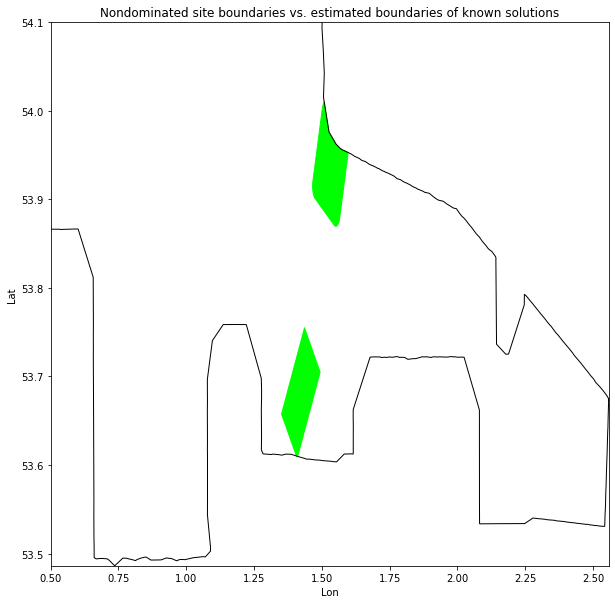

In [142]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site boundaries vs. estimated boundaries of known solutions")

for idx, row in sampled.iterrows():
    lon, lat = row['center_lon'], row['center_lat']
    turbnum = row['turbnum']
    rotation = row['rotation']

    q1_coord, q2_coord, q3_coord, q4_coord = getCorners(lon, lat, turbnum)   

    def rotate(points, origin, angle):
        xy = (points - origin) * np.exp(complex(0, angle)) + origin
        return xy.real, xy.imag
    
    q1_coord = rotate(complex(q1_coord[0], q1_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q2_coord = rotate(complex(q2_coord[0], q2_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q3_coord = rotate(complex(q3_coord[0], q3_coord[1]), complex(lon, lat), np.deg2rad(rotation))
    q4_coord = rotate(complex(q4_coord[0], q4_coord[1]), complex(lon, lat), np.deg2rad(rotation))

    points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
    polygon = Polygon(points)
    print(polygon.area)
    
    target = polygon.area
    maxR = pow(target/3.141593, 0.5)
    tolerance = 0.0000000001
    lower_bound = 0.0001

    # iterate till area outside of map polygon is less than lower bound (redistributed back inside polygon)
    while True:
        difference = polygon.difference(map_polygon)
        intersection = polygon.intersection(map_polygon)

        if not difference.is_empty and (difference.area / polygon.area) > lower_bound:
            
            low, high = 0, maxR

            while True:
                middle=0.5*(low+high)
                
                newPolygon = intersection.buffer(middle)
                
                if (high-low) < tolerance:
                    break
                
                if newPolygon.area < target:
                    low = middle
                else:
                    high = middle
            
            polygon = newPolygon
        else:
            break   # exit once difference is empty or below lower bound
    
    print(polygon.area)

    patch = PolygonPatch(polygon, fc="#00ff00", ec="#00ff00", fill=True)
    ax.add_patch(patch)

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

pl.show()

In [143]:
# drop Velocity Potential, Stability, Shipping Density, Wrecks and Obstructions, and Original
save = sampled[["rotation", "center_lon", "center_lat", "turbnum"]]

# save results to csv
save.to_csv("UK east coast optimised wind known energy locations.csv", index=False)

In [144]:
for idx, row in known_owf_locations.iterrows():
    sol = Solution(problem)
    sol.variables[:] = [0, row["LNG"], row["LAT"], row["TURBNUM"]]
    problem.evaluate(sol)
    
    sampled.loc[len(sampled.index)] = [*sol.variables, *sol.objectives, True]

# invert velocity potential
sampled["Velocity Potential"] = -sampled["Velocity Potential"]
sampled

outer_count: 7, inner_count: 13
outer_count: 0, inner_count: 0


,rotation,center_lon,center_lat,turbnum,Velocity Potential,Stability,Shipping Density,Wrecks and Obstructions,Original
0,247,1.541901,53.959745,165.0,2.662734e+06,2.815537e+06,3.904668,0,False
1,49,1.422626,53.681258,174.0,2.690310e+06,2.814097e+06,52.440110,0,False
2,0,1.541901,53.959745,165.0,2.660902e+06,2.815521e+06,3.904851,0,True
3,0,1.422626,53.681258,174.0,2.690172e+06,2.814115e+06,52.433040,0,True
